# ANOVA utilising *scipy.stats* & the *statsmodels* Python libraries

--- 

**Analysis of variance (ANOVA)**  
A one-way ANOVA is a test that is used to find out whether there exists a statistically significant difference between the mean values of more than one group.


### Importing the required libraries and modules

In [1]:
#Numerical arrays & dataframes
import numpy as np
import pandas as pd

#Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

#statistics
import scipy.stats as ss

#ANOVA
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Parameters for enhancing the legibility of data visualisation i.e., graphs

In [2]:
size=20
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 15}
plt.rcParams.update(params)

### Loading in the dataset 

In [3]:
#The scikit-learn library has some embedded datasets that have already been preprocessed
from sklearn.datasets import load_wine

#Loading in the dataset as a pandas dataframe
data = load_wine(as_frame = True)
df = data.frame

### Exploratory data analysis (EDA)

#### Dataset description

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are **thirteen** different
measurements taken for different constituents found in the **three types of wine**.

In [4]:
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

#### Dataset sample sizes of each type of wine

In [5]:
#How the different types of wine are defined within the dataset
category = data.target_names
for i in category:
    print(i)

class_0
class_1
class_2


In [6]:
#Counting the instances of each type of wine
wine_category_count = df['target'].value_counts()
wine_category_count

1    71
0    59
2    48
Name: target, dtype: int64

The above cells have informed of that within the dataset there are:
- Three different types of wine
    - 71 instances of class 1
    - 59 instances of class 0
    - 48 instances of class 2

### Reformatting the dataset to have equal sample sizes i.e., 45 instances of each wine type

In [7]:
class0 = df[df['target'] == 0]
class1 = df[df['target'] == 1]
class2 = df[df['target'] == 2]

In [8]:
#Creation of a seed for random number generation
seed = 14

#Creating a subset of the dataset with 45 instances of each wine type
subset_class0 = class0.sample(45, random_state=seed)
subset_class1 = class1.sample(45, random_state=seed)
subset_class2 = class2.sample(45, random_state=seed)

### Creation of a new dataframe that contains the data from each of the subsets

In [9]:
n_df = pd.concat([subset_class0, subset_class1, subset_class2])

In [10]:
#Renaming the target column to wine type
n_df = n_df.rename(columns={'target' : 'wine_type'})
#Modifying the wine type column to be of a string
n_df = n_df.astype({ 'wine_type' : 'string'})

In [11]:
#### Relabeling the string values for the wine types within the dataset
n_df.loc[n_df['wine_type'] == '0', 'wine_type'] = "wine 0"
n_df.loc[n_df['wine_type'] == '1', 'wine_type'] = "wine 1"
n_df.loc[n_df['wine_type'] == '2', 'wine_type'] = "wine 2"

In [12]:
n_df = n_df[['alcohol', 'wine_type']]
n_df = n_df.reset_index(drop=True)

In [13]:
n_df.head()

,alcohol,wine_type
0,13.58,wine 0
1,13.83,wine 0
2,13.16,wine 0
3,14.39,wine 0
4,13.82,wine 0


---

## Establishing our hypothesis

---

H0: true mean **alcohol** levels are the *same* for the various wine types  
H1: true mean **alcohol** levels are *not the same* for the various wine types

## ANOVA Assumptions

---

### Assumption 1
The dependent variable should be of a **continous** value i.e., measured at the interval or ratio level.

In [14]:
# The dependent variable
dependent = n_df['alcohol']
dependent

0      13.58
1      13.83
2      13.16
3      14.39
4      13.82
       ...  
130    12.93
131    14.34
132    13.58
133    12.53
134    13.11
Name: alcohol, Length: 135, dtype: float64

In [15]:
dependent.describe()

count    135.000000
mean      13.063259
std        0.780158
min       11.460000
25%       12.420000
50%       13.050000
75%       13.685000
max       14.830000
Name: alcohol, dtype: float64

### Assumption 2
The independent variable should be of a **categorical** value and contain two or more categorical, independent groups.b

In [16]:
# As previously highlighted, there are three categorical groups i.e., wine types
independent = n_df['wine_type']

print(independent.unique())

<StringArray>
['wine 0', 'wine 1', 'wine 2']
Length: 3, dtype: string


### Assumption 3
There should be **indepence of observations** i.e., there should be no relationship between the observations in each group or between the groups themselves.

The dataset meets this assumption.

### Assumption 4
There should be no significant outliers.

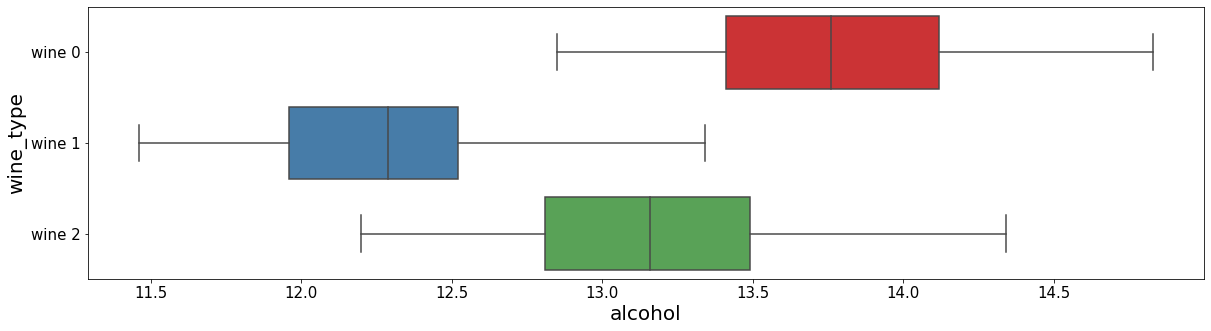

In [17]:
sns.boxplot(x=dependent, y=n_df['wine_type'], palette="Set1");

### Assumption 5
The dependent variable should be approximately normally distributed for each category of the independent variable.

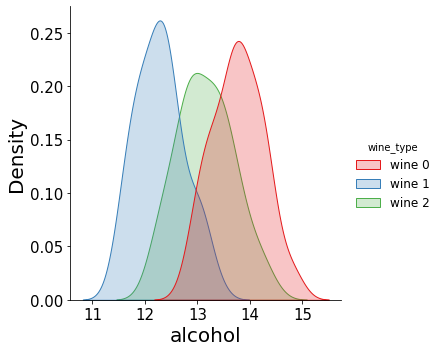

In [18]:
sns.displot(data=n_df, x=n_df['alcohol'], hue="wine_type", kind='kde', fill=True, palette="Set1");

#### Shapiro-Wilk test for each categorical value

In [19]:
ss.shapiro(dependent[independent == 'wine 0'])

ShapiroResult(statistic=0.9816116094589233, pvalue=0.6853755712509155)

In [20]:
ss.shapiro(dependent[independent == 'wine 1'])

ShapiroResult(statistic=0.9752582907676697, pvalue=0.4418913722038269)

In [21]:
ss.shapiro(dependent[independent == 'wine 2'])

ShapiroResult(statistic=0.9815422296524048, pvalue=0.6825376749038696)

### Assumption 6
There needs to be homogeneity of variances

In [22]:
# Test for equal variances.
ss.levene(
    dependent[independent == 'wine 0'],
    dependent[independent == 'wine 1'],
    dependent[independent == 'wine 2']
)

LeveneResult(statistic=0.7074817082087027, pvalue=0.4947430740742381)

## ANOVA utilising the scipy.stats Python library
---

In [23]:
fstatistic, pvalue = f_oneway(dependent[independent == 'wine 0'], dependent[independent == 'wine 1'], dependent[independent == 'wine 2'])

In [24]:
#The computed F statistic of the test.
fstatistic

102.65724406327112

In [25]:
#The associated p-value from the F distribution.
pvalue

1.2810609123091256e-27

## ANOVA utilising the statsmodels Python library
---

In [26]:
#Modifying the wine type column to be of type object
n_df = n_df.astype({ 'wine_type' : 'object'})

In [27]:
model = ols('alcohol ~ wine_type', data=n_df).fit()

anova_result = sm.stats.anova_lm(model, typ=2)

In [28]:
anova_result

,sum_sq,df,F,PR(>F)
wine_type,49.642561,2.0,102.657244,1.281061e-27
Residual,31.916004,132.0,NaN,NaN


With our p-value being **less** than that of *0.001*, we can reject the null hypothesis and propose that the true mean alcohol levels are not the same for the various wine types.

---

# References
---

Bobbitt, Z (2020) How to Perform a One-Way ANOVA in Python. Available at: https://www.statology.org/one-way-anova-python/ (Accessed: 1 August 2022).  

Bobbitt, Z (2018) Introduction to Hypothesis Testing. Available at: https://www.statology.org/hypothesis-testing/ (Accessed: 1 August 2022).  

laerd statistics (no date) One-way ANOVA in SPSS Statistics. Available at: https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php (Accessed: 1 August 2022).  

statsmodels user guide (no date) ANOVA. Available at: https://www.statsmodels.org/stable/anova.html#examples (Accessed: 1 August 2022).  
